### 🧠 Pneumonia Detection – Modular Pipeline
This notebook loads all source files from the `src` folder and runs the complete workflow — from data loading to Grad-CAM visualization.


In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image_dataset_from_directory

# ✅ Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

2025-11-07 09:50:40.535946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762509040.727988      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762509040.780869      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ✅ Add custom project folder (where all .py files are located)
sys.path.append("/kaggle/input/project-file/src")

# ✅ Verify all files exist
print("📂 Project Files in /src/:")
print(os.listdir("/kaggle/input/project-file/src"))

📂 Project Files in /src/:
['evaluate.py', 'model_builder.py', 'data_loader.py', 'gradcam_visualizer.py', 'config.py', 'train_fine_tune.py', 'train_feature_extraction.py']


In [3]:
# ✅ Import project modules
import config
import data_loader
import train_feature_extraction
import train_fine_tune
import evaluate
import gradcam_visualizer
from data_loader import get_data_augmentation

### 📂 Load Dataset
Load and prepare the Chest X-Ray dataset for training, validation, and testing.


In [4]:
train_ds, val_ds, test_ds = data_loader.load_datasets()
class_weights = data_loader.get_class_weights(train_ds)
data_augmentation = get_data_augmentation()

Found 5216 files belonging to 2 classes.
Using 4434 files for training.


I0000 00:00:1762509085.061623      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 5216 files belonging to 2 classes.
Using 782 files for validation.
Found 624 files belonging to 2 classes.
✅ Datasets Loaded: 139 train batches, 25 val batches, 20 test batches.
✅ Computed class weights: {0: 1.9261511728931364, 1: 0.675296984465428}


### 🏗️ Build Model
Create the transfer learning model using ResNet50 as the feature extractor.


In [5]:
from model_builder import build_feature_extraction_model

# ✅ Build the model
model, base_model = build_feature_extraction_model(data_augmentation)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
model.summary()

Model: "resnet50_feature_extraction"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess (Lambda)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,625 (90.98 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

### 🚀 Train Head Layers (Feature Extraction)
Train only the top layers while keeping the ResNet50 base frozen.


In [7]:
from train_feature_extraction import train_model
history_head = train_model(model, train_ds, val_ds, class_weights)


🚀 Starting Feature Extraction Training...

Epoch 1/20


I0000 00:00:1762509135.994660     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


139/139 ━━━━━━━━━━━━━━━━━━━━ 36s 145ms/step - accuracy: 0.6147 - auc: 0.7095 - loss: 0.9790 - val_accuracy: 0.7967 - val_auc: 0.9739 - val_loss: 0.7121 - learning_rate: 1.0000e-04
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.7867 - auc: 0.9266 - loss: 0.6376 - val_accuracy: 0.8772 - val_auc: 0.9801 - val_loss: 0.5501 - learning_rate: 1.0000e-04
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.8192 - auc: 0.9467 - loss: 0.5681 - val_accuracy: 0.8862 - val_auc: 0.9810 - val_loss: 0.5359 - learning_rate: 1.0000e-04
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.8441 - auc: 0.9591 - loss: 0.5213 - val_accuracy: 0.9271 - val_auc: 0.9841 - val_loss: 0.4439 - learning_rate: 1.0000e-04
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.8691 - auc: 0.9683 - loss: 0.4746 - val_accuracy: 0.9169 - val_auc: 0.9851 - val_loss: 0.4614 - learning_rate: 1.0000e-04
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accu

### 🔧 Fine-Tune Model
Unfreeze top layers of ResNet50 and retrain with a lower learning rate.


In [8]:
from config import BEST_HEAD_MODEL
from model_builder import build_fine_tuning_model
from train_fine_tune import finetune_model

finetune_model_obj, base_model = build_fine_tuning_model(BEST_HEAD_MODEL, data_augmentation)

✅ Fine-tuning from layer 145 onward (30 layers unfrozen)


In [ ]:
finetune_model_obj.summary()

In [9]:
history_finetune = finetune_model(finetune_model_obj, base_model, train_ds, val_ds, class_weights)


🚀 Starting Fine-Tuning Training...

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.8901 - auc: 0.9737 - loss: 0.4402 - val_accuracy: 0.9105 - val_auc: 0.9864 - val_loss: 0.4828 - learning_rate: 1.0000e-05
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9275 - auc: 0.9858 - loss: 0.3612 - val_accuracy: 0.9258 - val_auc: 0.9898 - val_loss: 0.4341 - learning_rate: 1.0000e-05
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9393 - auc: 0.9827 - loss: 0.3679 - val_accuracy: 0.9335 - val_auc: 0.9928 - val_loss: 0.4035 - learning_rate: 1.0000e-05
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9507 - auc: 0.9912 - loss: 0.3191 - val_accuracy: 0.9348 - val_auc: 0.9935 - val_loss: 0.3986 - learning_rate: 1.0000e-05
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9551 - auc: 0.9943 - loss: 0.2988 - val_accuracy: 0.9437 - val_auc: 0.9947 - val_loss: 0.3784 - learning_rate: 1.0000e-05
Epoch 6/

### 📊 Evaluate Model
Evaluate accuracy, AUC, and classification metrics on the test set.



🚀 Starting evaluation for: Feature Extraction
Found 624 files belonging to 2 classes.
✅ Model loaded successfully!
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step

📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.71      0.79       234
         1.0       0.85      0.94      0.89       390

    accuracy                           0.86       624
   macro avg       0.86      0.83      0.84       624
weighted avg       0.86      0.86      0.85       624



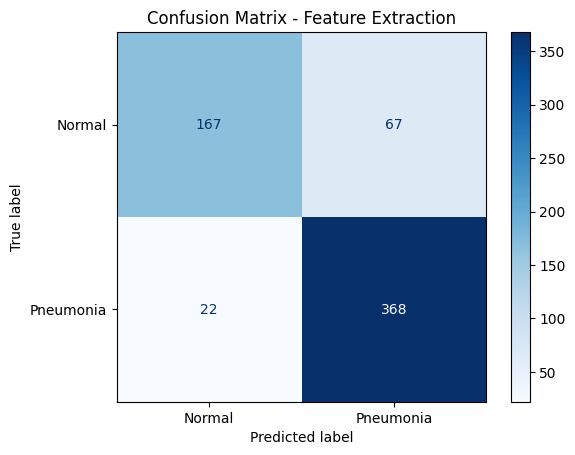

✅ Confusion matrix saved successfully at: /kaggle/working/assets/confusion_matrix_feature_extraction.png
ℹ️ Skipping ROC curve for Feature Extraction model (only for fine-tuned model).

🚀 Starting evaluation for: Fine-tuned
Found 624 files belonging to 2 classes.
✅ Model loaded successfully!
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step

📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.76      0.84       234
         1.0       0.87      0.96      0.91       390

    accuracy                           0.89       624
   macro avg       0.90      0.86      0.88       624
weighted avg       0.89      0.89      0.89       624



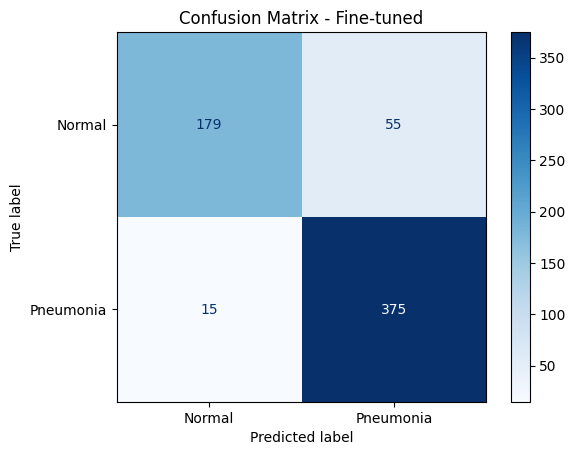

✅ Confusion matrix saved successfully at: /kaggle/working/assets/confusion_matrix_fine-tuned.png


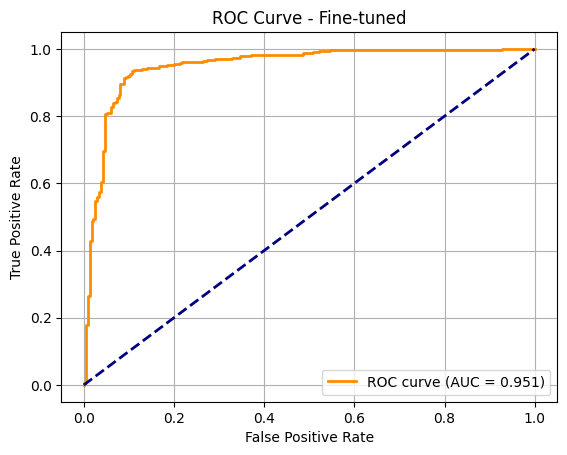

✅ ROC curve saved successfully at: /kaggle/working/assets/roc_curve_fine-tuned.png


In [10]:
# 🔹 Evaluate Models on Test Dataset
from evaluate import evaluate_model

# Define correct Kaggle model paths
BEST_HEAD_MODEL = "/kaggle/working/model/best_resnet_head.keras"
FINAL_MODEL = "/kaggle/working/model/final_resnet_pneumonia_model.keras"

# Run evaluation for both models
evaluate_model(BEST_HEAD_MODEL, "Feature Extraction")
evaluate_model(FINAL_MODEL, "Fine-tuned")

### 🔥 Grad-CAM Visualization
Generate and save Grad-CAM overlays to visualize model focus areas.


Model loaded.
Found 624 files belonging to 2 classes.
✅ Test dataset loaded successfully: 20 batches.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
✅ True label: 1, Predicted class: 1, Probability: 0.9955
✅ Using last conv layer: conv5_block3_3_conv


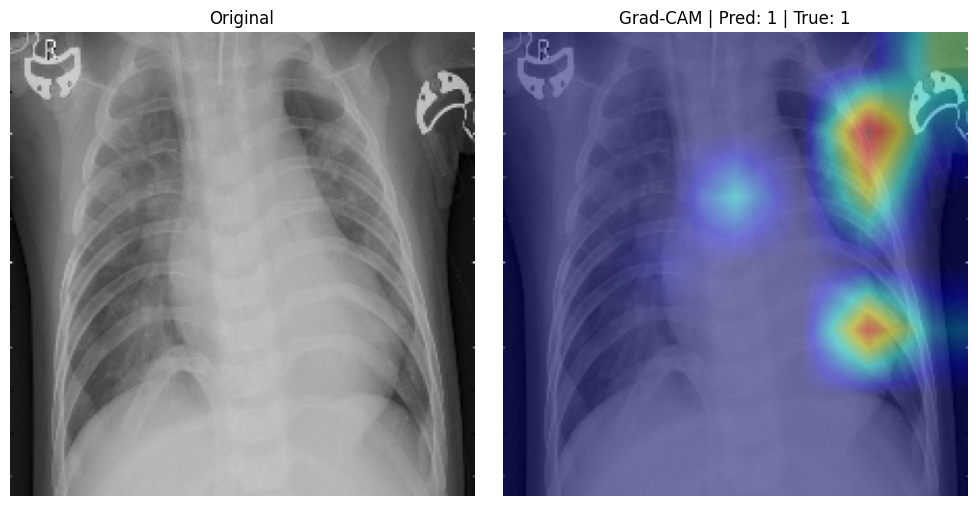

✅ Grad-CAM saved to: /kaggle/working/GradCAM_ResNet50_Fixed.png


In [11]:
from config import FINAL_MODEL_PATH, _preprocess_input
from data_loader import load_test_dataset
from tensorflow.keras.models import load_model
from gradcam_visualizer import generate_gradcam

model = load_model(FINAL_MODEL_PATH, custom_objects={'_preprocess_input': _preprocess_input})
print("Model loaded.")

test_ds = load_test_dataset()
test_images, test_labels = next(iter(test_ds))

generate_gradcam(model, test_images, test_labels, index=1, save_path="/kaggle/working/GradCAM_ResNet50_Fixed.png")